# Gaussian Process Regression using GPyTorch

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from utils import nc_to_pd, prepare_simulated

from sklearn.preprocessing import StandardScaler

import math
import torch
import gpytorch

from matplotlib import pyplot as plt

In [2]:
if sys.platform == 'win32':
    save_folder = "D:/Google Drive/Dropbox_Backup/Post Study/Industrial/Courses/DTU Advanced Machine Learning, 2020/gaussian_solar_project/data/"
else:
    save_folder = "/home/local/DAC/ahn/Documents/dcwis.solar/dcwis/solar/reports/dtu/"

In [3]:
meuro_sim = pd.read_csv(save_folder + 'meuro_simulated.csv', skiprows=[0,1,2])
neuhardenberg_sim = pd.read_csv(save_folder + 'neuhardenberg_simulated.csv', skiprows=[0,1,2])
templin_sim = pd.read_csv(save_folder + 'templin_simulated.csv', skiprows=[0,1,2])

In [4]:
meuro_irradiance = pd.read_csv(save_folder + 'irradiance_meuro_data.csv').set_index('time')
meuro_irradiance.index = pd.to_datetime(meuro_irradiance.index, utc=True)

neuhardenberg_irradiance = pd.read_csv(save_folder + 'irradiance_neuhardenberg_data.csv').set_index('time')
neuhardenberg_irradiance.index = pd.to_datetime(neuhardenberg_irradiance.index, utc=True)

templin_irradiance = pd.read_csv(save_folder + 'irradiance_templin_data.csv').set_index('time')
templin_irradiance.index = pd.to_datetime(templin_irradiance.index, utc=True)

In [5]:
# prepare our simulated dataframes
meuro_sim = prepare_simulated(meuro_sim, meuro_irradiance.index)
neuhardenberg_sim = prepare_simulated(neuhardenberg_sim, neuhardenberg_irradiance.index)
templin_sim = prepare_simulated(templin_sim, templin_irradiance.index)

In [6]:
meuro_sim = meuro_sim[meuro_sim.values>0]

meuro_irradiance = meuro_irradiance.loc[meuro_sim.index]

In [7]:
# Let us start considering the Meuro dataset

In [8]:
x = meuro_irradiance.values.reshape(-1, 1)
y = meuro_sim.values.reshape(-1, 1)

# In[8]:

# We start by standardizing the data, note we save the standardizers in case we want to add back the mean
x_scaler = StandardScaler().fit(x)
y_scaler = StandardScaler().fit(y)

x = x_scaler.transform(x)
y = y_scaler.transform(y)

x = torch.from_numpy(x.ravel())
y = torch.from_numpy(y.ravel())

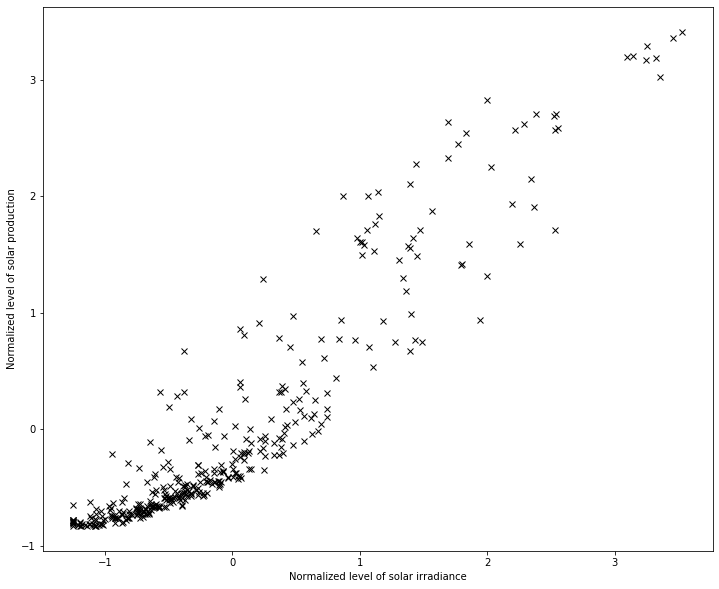

In [9]:
# and plot it
plt.figure(figsize=(12,10))
plt.plot(x, y, 'rx', color='black')
plt.ylabel('Normalized level of solar production')
plt.xlabel('Normalized level of solar irradiance')
plt.show()

In [10]:
# we shall also define the test set, that is the range of XTest points we want to 
# use to compute the mean and the variance
Xtest = np.linspace(-1, 4, 1000).reshape(-1,1)

In [109]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
#         self.covar_module =gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel() + gpytorch.kernels.LinearKernel() + gpytorch.kernels.PeriodicKernel()) 
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())# + gpytorch.kernels.LinearKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [110]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(x, y, likelihood)

In [111]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [112]:
# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

In [113]:
# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [114]:
training_iter = 50

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(x)
    # Calc loss and backprop gradients
    loss = -mll(output, y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item(),
    ))
    optimizer.step()


Iter 1/50 - Loss: 0.862   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.827   lengthscale: 0.744   noise: 0.644
Iter 3/50 - Loss: 0.793   lengthscale: 0.798   noise: 0.598
Iter 4/50 - Loss: 0.760   lengthscale: 0.853   noise: 0.554
Iter 5/50 - Loss: 0.727   lengthscale: 0.909   noise: 0.513
Iter 6/50 - Loss: 0.694   lengthscale: 0.966   noise: 0.474
Iter 7/50 - Loss: 0.662   lengthscale: 1.022   noise: 0.437
Iter 8/50 - Loss: 0.630   lengthscale: 1.078   noise: 0.403
Iter 9/50 - Loss: 0.599   lengthscale: 1.134   noise: 0.371
Iter 10/50 - Loss: 0.569   lengthscale: 1.187   noise: 0.341
Iter 11/50 - Loss: 0.539   lengthscale: 1.239   noise: 0.313
Iter 12/50 - Loss: 0.511   lengthscale: 1.289   noise: 0.288
Iter 13/50 - Loss: 0.484   lengthscale: 1.336   noise: 0.264
Iter 14/50 - Loss: 0.458   lengthscale: 1.382   noise: 0.242
Iter 15/50 - Loss: 0.433   lengthscale: 1.425   noise: 0.222
Iter 16/50 - Loss: 0.411   lengthscale: 1.465   noise: 0.203
Iter 17/50 - Loss: 0.390   length

In [115]:
# Make predictions on another power plant

x_test = neuhardenberg_irradiance.values.reshape(-1, 1)
y_test = neuhardenberg_sim.values.reshape(-1, 1)

x_test_scaler = StandardScaler().fit(x_test)
y_test_scaler = StandardScaler().fit(y_test)

x_test = x_test_scaler.transform(x_test)
y_test = y_test_scaler.transform(y_test)


# We convert variables to torch tensors
x_test = torch.from_numpy(x_test.ravel())
y_test = torch.from_numpy(y_test.ravel())

_, indices = torch.sort(x_test, 0)

In [123]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(x_test))

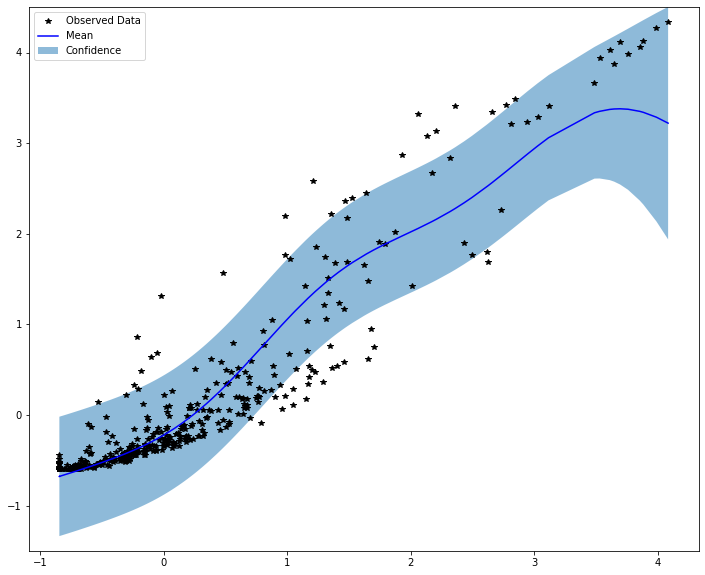

In [124]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(12, 10))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(x_test.numpy(), y_test.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(x_test.numpy()[indices].ravel(), observed_pred.mean.numpy()[indices], 'b')

    # Shade between the lower and upper confidence bounds
    ax.fill_between(x_test.numpy()[indices].ravel(), lower.numpy()[indices].ravel(), upper.numpy()[indices].ravel(), alpha=0.5)
    ax.set_ylim([-1.5, 4.5])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [118]:
# Calculate log likelihood

K = observed_pred.covariance_matrix

In [94]:
y_ = y_test.reshape(y_test.shape[0], 1)

In [95]:
loglike = -(-.5 * y_.transpose(1,0)@torch.inverse(K)@y_test - 0.5* torch.logdet(K) - .5 * len(x_test) * np.log(2*np.pi))
print('Log likelihood is {}'.format(round(loglike.item(), 2)))

print('Entropy is {}'.format(round(observed_pred.entropy().item(), 2)))

Log likelihood is 656.8


RuntimeError: cholesky_cpu: U(3,3) is zero, singular U.

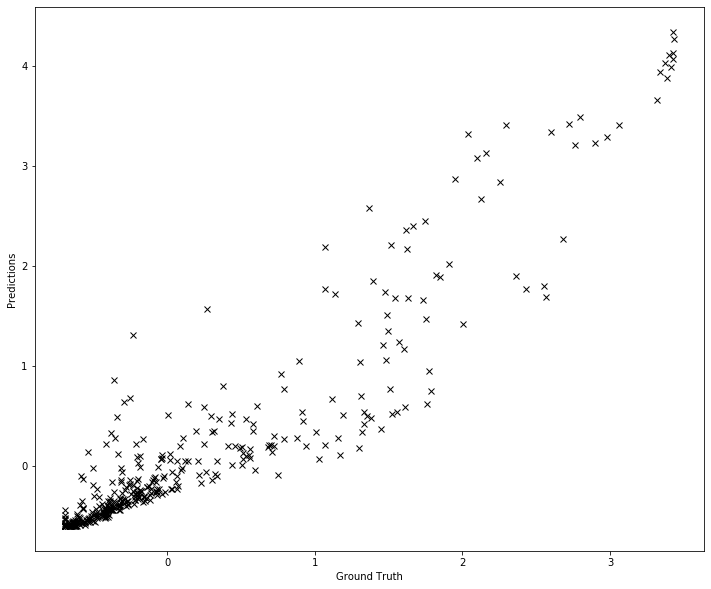

In [26]:
# and plot it
plt.figure(figsize=(12,10))
plt.plot(observed_pred.mean.numpy() , y_test.numpy(), 'rx', color='black')
plt.ylabel('Predictions')
plt.xlabel('Ground Truth')
plt.show()

In [27]:
pred_y = y_test_scaler.inverse_transform(observed_pred.mean.numpy())

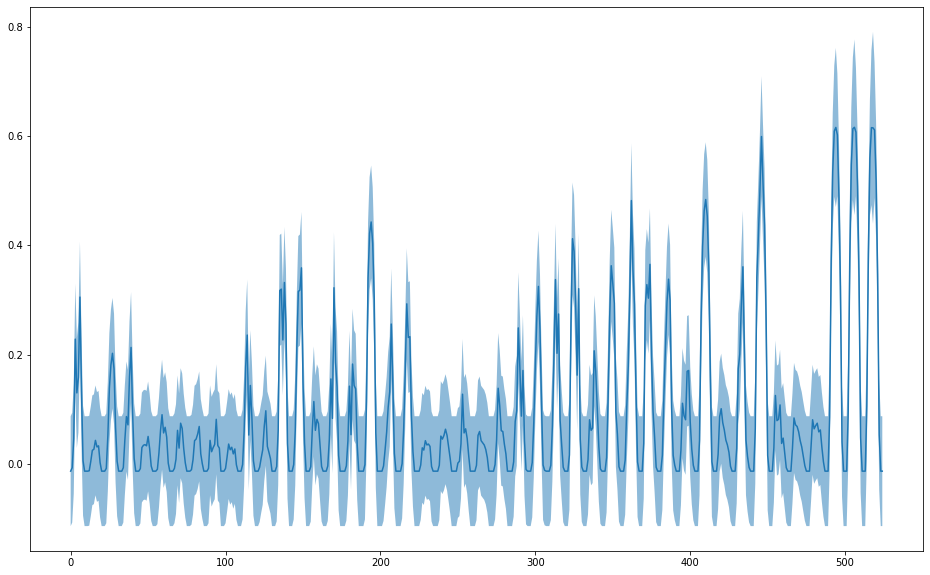

In [28]:
f, ax = plt.subplots(1, 1, figsize=(16, 10))

plt.plot(pred_y)

ax.fill_between(np.arange(len(pred_y)), y_test_scaler.inverse_transform(lower.numpy()), y_test_scaler.inverse_transform(upper.numpy()), alpha=0.5)

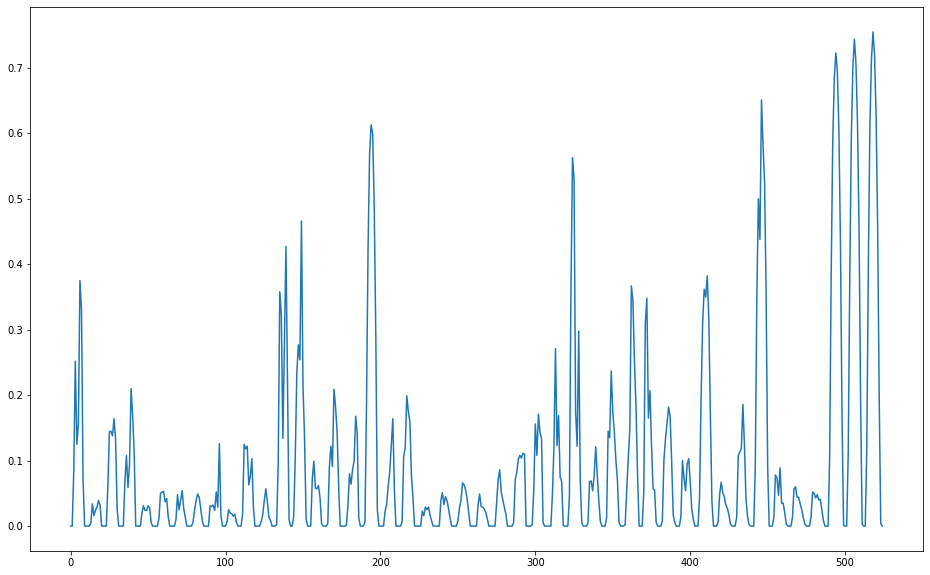

In [29]:
plt.figure(figsize=(16,10))
plt.plot(neuhardenberg_sim.values.reshape(-1, 1))

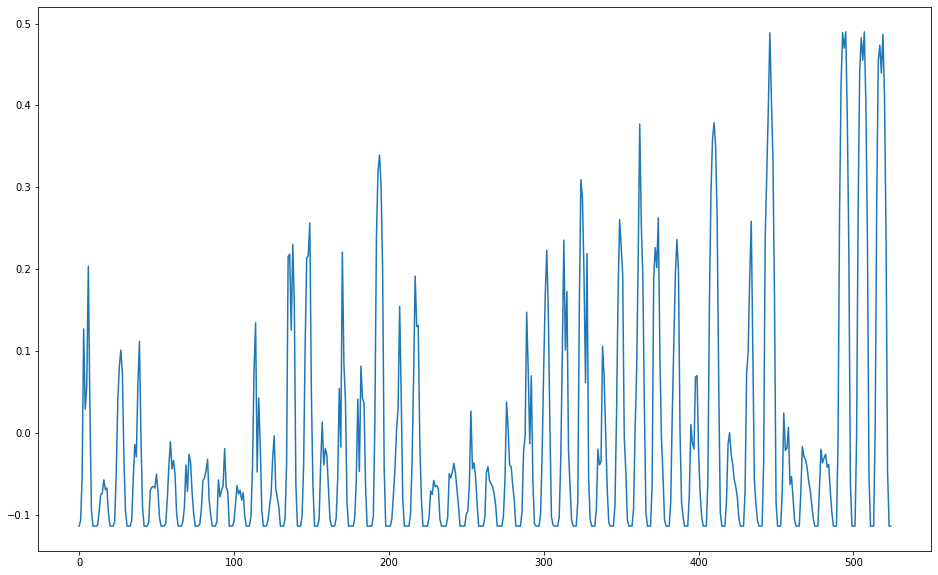

In [30]:
plt.figure(figsize=(16,10))
plt.plot(y_test_scaler.inverse_transform(lower.numpy()))

tensor([-1.3498, -1.3077, -0.9613,  0.2276, -0.4141, -0.2295,  0.7304, -0.3906,
        -1.2244, -1.3498, -1.3498, -1.3498, -1.3448, -1.2306, -1.0995, -1.0862,
        -0.9805, -1.0593, -1.0455, -1.2460, -1.3498, -1.3498, -1.3498, -1.3159,
        -0.9335, -0.3584, -0.0796,  0.0584, -0.1276, -0.8242, -1.2306, -1.3498,
        -1.3498, -1.3498, -1.3077, -0.9729, -0.6967, -0.7954, -0.2205,  0.1284,
        -0.6569, -1.1961, -1.3498, -1.3498, -1.3498, -1.3186, -1.0661, -1.0386,
        -1.0315, -1.0455, -0.9335, -1.0795, -1.2878, -1.3498, -1.3498, -1.3498,
        -1.3267, -1.1321, -0.8655, -0.6742, -0.8917, -0.8242, -0.9416, -1.2521,
        -1.3498, -1.3498, -1.3498, -1.3159, -1.2056, -0.8610, -1.0728, -0.7757,
        -0.8382, -1.0795, -1.2490, -1.3498, -1.3498, -1.3498, -1.3320, -1.2119,
        -0.9842, -0.9652, -0.9045, -0.8147, -1.1418, -1.2612, -1.3498, -1.3498,
        -1.3498, -1.3159, -0.9805, -1.1159, -1.0661, -1.0280, -0.7292, -1.0420,
        -1.0728, -1.3498, -1.3498, -1.34

# Additional - comparison with linear regression

In [31]:
# Let us calculate rmse of our GP
rmse_gp = np.mean(np.sqrt(np.power(pred_y - neuhardenberg_sim.values.reshape(-1, 1), 2)))

In [32]:
from sklearn.linear_model import LinearRegression

In [33]:
model = LinearRegression()

model.fit(meuro_irradiance.values.reshape(-1, 1), meuro_sim.values.reshape(-1, 1))

preds_ols = model.predict(neuhardenberg_irradiance.values.reshape(-1, 1),)

In [34]:
rmse_ols = np.mean(np.sqrt(np.power(preds_ols.ravel() - neuhardenberg_sim.values.reshape(-1, 1), 2)))

In [35]:
print('RMSE of GP model is {}'.format(round(rmse_gp, 4)))
print('RMSE of OLS model is {}'.format(round(rmse_ols, 4)))

RMSE of GP model is 0.1362
RMSE of OLS model is 0.1524


### Thus, we can observe our GP model actually provide a more accurate estimate than OLS!
Additionally, we obtain uncertainty estimates which makes it even more valuable compared to the linear parametric model!

In [ ]:
# We experimented with the GPytorch package, and we could obtain the following result